In [ ]:
# To do:
# special thank you to ... 
# create markdown sections (including fMRIPrep website, nilearn website etc.) and put references
# improve comments and add print statements to facilitate human understanding
# add error tests
# 
# load afni files
# load atlas(es) for parcellation (standard and/or data-driven)
#
# Nilearn for FC (normal corr, partial corr or tangent space embedding, the latter of which has been shown to be the best?) 
# Graphpype (from Neuropycon) to calculate graph theory metrics
# Analysis of graph metrics, FC and neuropsych scores etc. using PCA, CCA and then SVM, e.g. ?????????
# 
# hypotheses and contrasts
# significance testing and multiple comparisons correction (e.g. Permutation testing or Hierarchical Bayes??)
# 
# Also check the EverNote notes !!!!!

In [ ]:
# This script is to be used on pre-processed fMRI timeseries data 

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Copy the script onto the external HDD and try it from there???? !!!!!!!!!!!

In [55]:
import glob
import os

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from scipy import stats
from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import xlrd
import itertools

from nipype.interfaces import afni
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import input_data
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.masking import compute_multi_gray_matter_mask
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_design_matrix

import graph_tool.all as gt

from sklearn.preprocessing import StandardScaler

In [15]:
# load an image from a single brain:
fmri_image_folder = "/Volumes/Seagate Dr/PhD/Chapter 2"
fmri_image_path = os.path.join(fmri_image_folder, "F001_B.nii")
fmri_image = nib.load(fmri_image_path)
print(fmri_image.shape)

(55, 65, 55, 182)



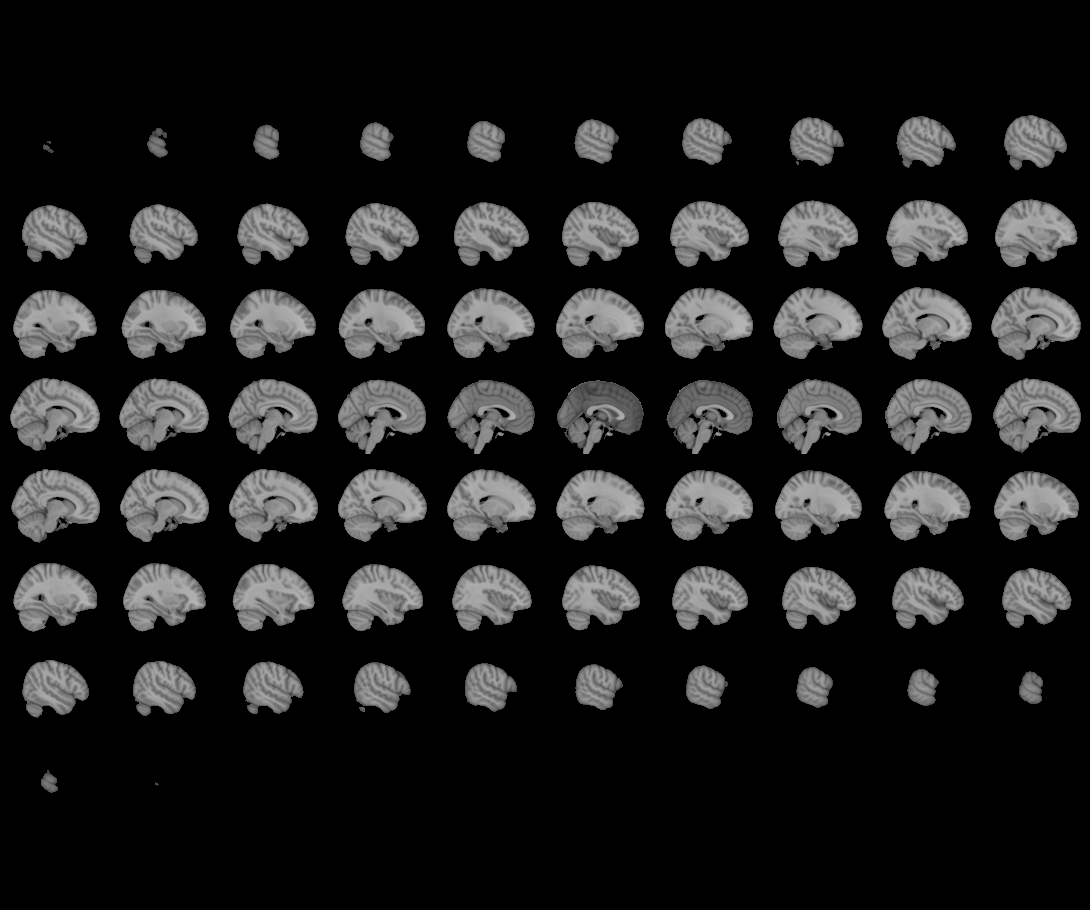
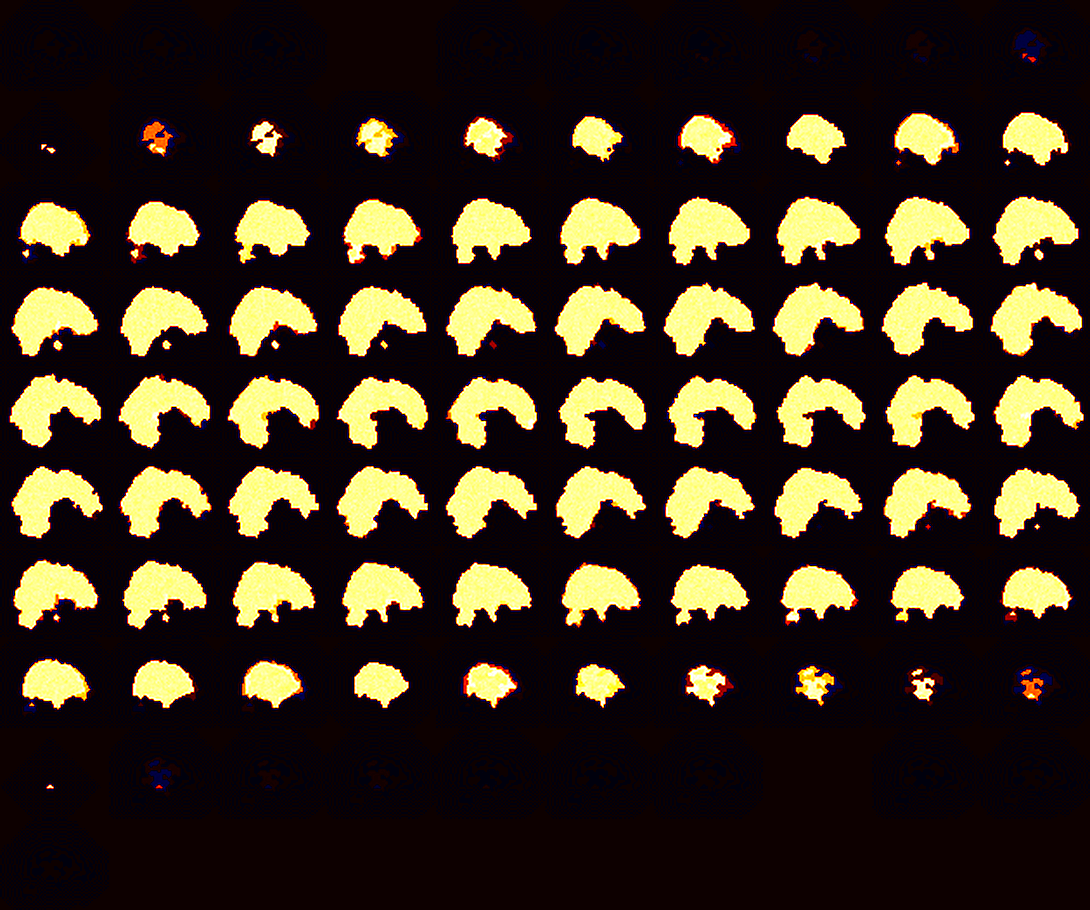

In [16]:
# to look at the mean fMRI brain image for a single participant
mean_image = image.mean_img(fmri_image)
plotting.view_img(mean_image, threshold=None)

In [5]:
full_fmri_image_list = sorted(glob.glob("/Volumes/Seagate Dr/PhD/Chapter 2/*"))
full_fmri_image_list

['/Volumes/Seagate Dr/PhD/Chapter 2/F001_A.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F001_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F002_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F002_C.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F003_A.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F003_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F003_C.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F004_A.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F004_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F004_C.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F005_A.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F005_C.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F006_A.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F006_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F006_C.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F007_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F007_C.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F008_A.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F008_B.nii',
 '/Volumes/Seagate Dr/PhD/Chapter 2/F008_C.nii',
 '/Volumes/Seagate D

In [11]:
# create a mask object and fit it to the whole dataset
# http://nilearn.github.io/modules/generated/nilearn.masking.compute_multi_gray_matter_mask.html
group_mask = compute_multi_gray_matter_mask(full_fmri_image_list)

/opt/anaconda3/envs/Project_2_ARB/lib/python3.9/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))



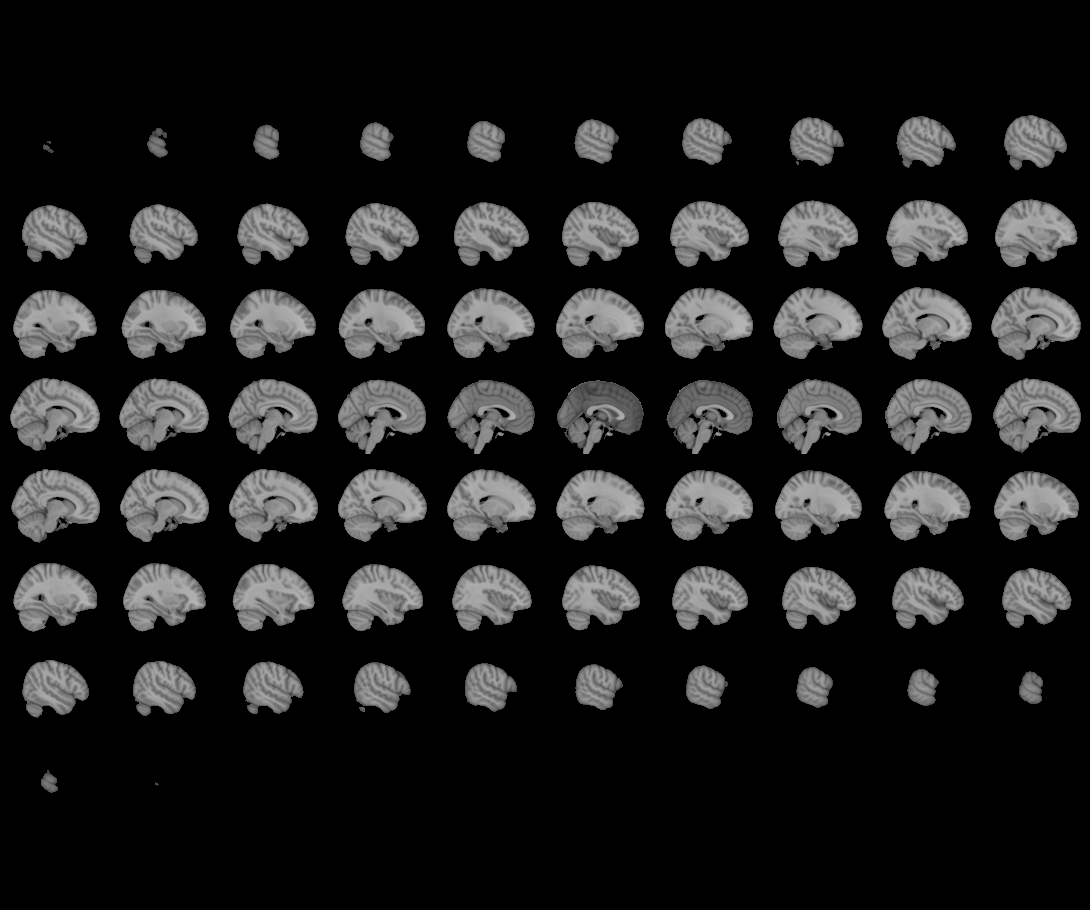
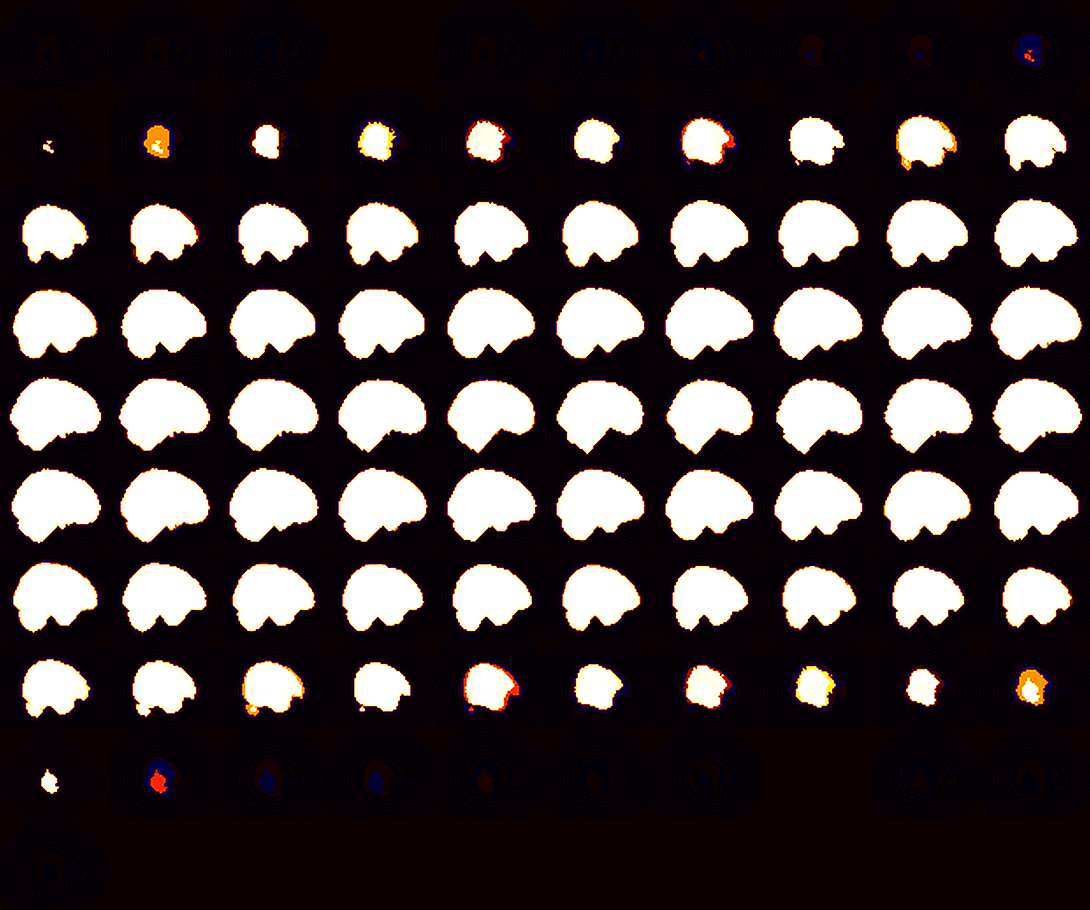

In [12]:
plotting.view_img(group_mask, threshold=None)

In [17]:
# create a NiftiMasker object
brain_masker = input_data.NiftiMasker(group_mask, detrend=True, standardize=True, t_r=2.5, memory='nilearn_cache', memory_level=1, verbose=0)
brain_time_series = brain_masker.fit_transform(fmri_image)

In [18]:
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

Brain time series shape: (182, 42655)


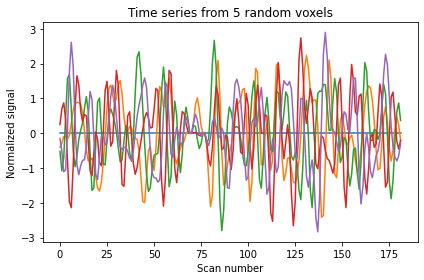

In [21]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [22]:
brain_time_series.mean()

5.503472e-11

In [ ]:
# SHOULD I CONVOLVE THE SIGNAL WITH HRF? / Use deconvolution to calculate HRF variability??
# https://pubmed.ncbi.nlm.nih.gov/29656446/
# https://pubmed.ncbi.nlm.nih.gov/30013915/

# check the paper by Holiga et al.,2019 !

# https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py


In [101]:
# https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

voxel_to_voxel_correlations = (np.matmul(brain_time_series.T, brain_time_series) /
                              brain_time_series.shape[0]
                              )

In [102]:
print("Voxel-to-voxel correlation shape: (%s, %s)" %
      voxel_to_voxel_correlations.shape)
print("Voxel-to-voxel correlation: min = %.3f; max = %.3f" % (
    voxel_to_voxel_correlations.min(), voxel_to_voxel_correlations.max()))

Voxel-to-voxel correlation shape: (34921, 34921)
Voxel-to-voxel correlation: min = -0.954; max = 1.000


In [10]:
type(voxel_to_voxel_correlations)

numpy.ndarray

In [11]:
voxel_to_voxel_correlations

array([[ 0.9999995 , -0.31734407,  0.29928797, ...,  0.18470444,
         0.15932947,  0.06040451],
       [-0.31734407,  0.9999998 ,  0.34549356, ...,  0.01804115,
        -0.00104034,  0.08121189],
       [ 0.29928797,  0.34549356,  1.0000001 , ...,  0.56715083,
         0.3224489 ,  0.15820917],
       ...,
       [ 0.18470444,  0.01804115,  0.56715083, ...,  1.0000001 ,
         0.8168269 ,  0.51636505],
       [ 0.15932947, -0.00104034,  0.3224489 , ...,  0.8168269 ,
         0.9999996 ,  0.8563969 ],
       [ 0.06040451,  0.08121189,  0.15820917, ...,  0.51636505,
         0.8563969 ,  1.0000001 ]], dtype=float32)

In [11]:
# threshold at r > 0.25
correlation_matrix = voxel_to_voxel_correlations
correlation_matrix[correlation_matrix < 0.25] = 0
#correlation_matrix

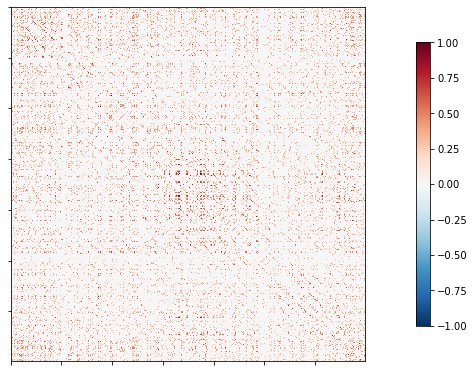

In [23]:
# # plot a connectivity matrix
# set this to a matrix of your choice
#correlation_matrix = voxel_to_voxel_correlations
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     #labels=harv_oxf_atlas.labels[1:],
                     vmax=1, vmin=-1, colorbar=True)

In [14]:
unique_elements, counts_elements = np.unique(correlation_matrix, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[0.00000000e+00 2.50000000e-01 2.50000030e-01 ... 1.00000119e+00
  1.00000131e+00 1.00000155e+00]
 [1.06742746e+09 2.20000000e+01 3.60000000e+01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


In [26]:
# check a small subset of the data to verify graph generation is accurate

In [13]:
adj = correlation_matrix[:5,:5]
# np.fill_diagonal(adj, 0) # fill diagonal with zeroes, if it hasn't been done already

In [14]:
adj

array([[0.        , 0.        , 0.29928797, 0.63431513, 0.42976892],
       [0.        , 0.        , 0.34549356, 0.        , 0.        ],
       [0.29928797, 0.34549356, 0.        , 0.7592736 , 0.38660288],
       [0.63431513, 0.        , 0.7592736 , 0.        , 0.80052704],
       [0.42976892, 0.        , 0.38660288, 0.80052704, 0.        ]],
      dtype=float32)

In [12]:
# https://carlonicolini.github.io/sections/science/2018/09/12/weighted-graph-from-adjacency-matrix-in-graph-tool.html

# to create an undirected, weighted graph

def to_graph_tool(adj):
    g = gt.Graph(directed=False)
    edge_weights = g.new_edge_property('double')
    g.edge_properties['weight'] = edge_weights
    nnz = np.nonzero(np.triu(adj,1))
    nedges = len(nnz[0])
    g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
    return g

In [15]:
gm = to_graph_tool(adj)

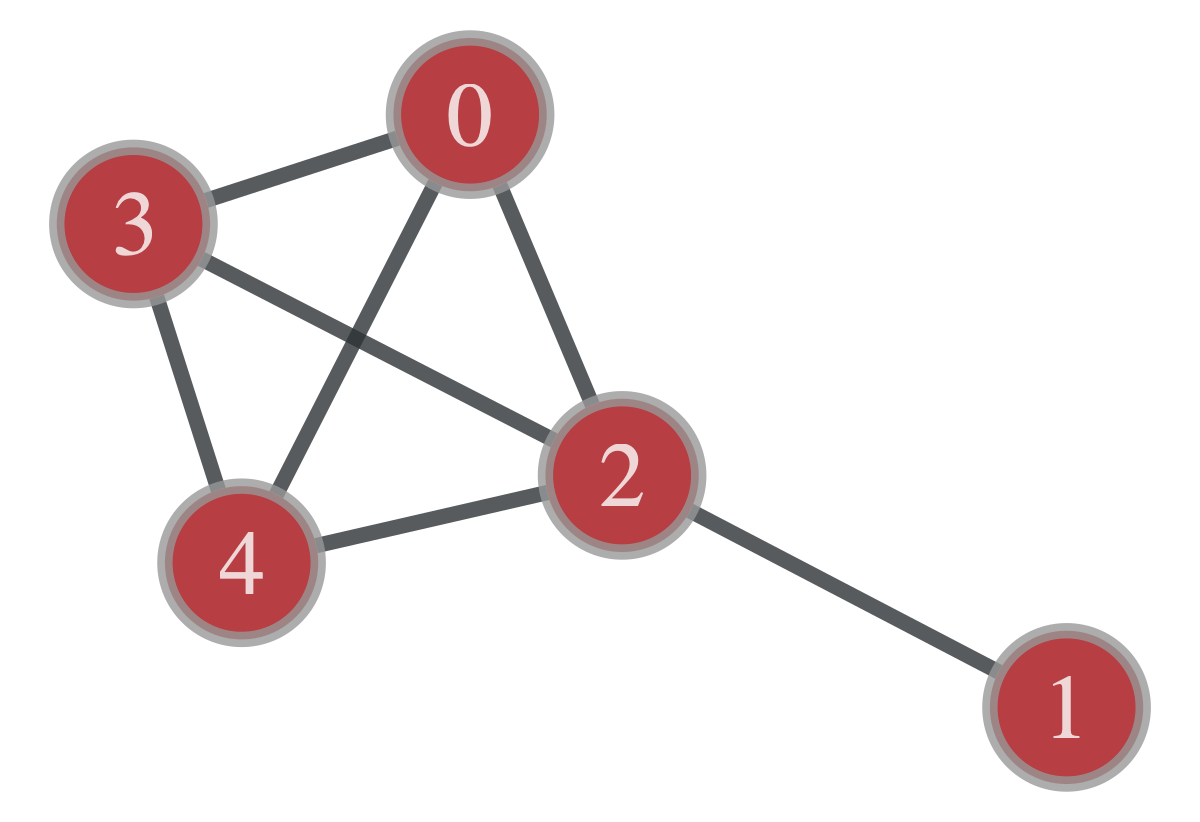

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1187fdd90, at 0x11884a610>

In [16]:
# draw the graph
# check https://www.slideshare.net/moskytw/graphtool-in-practice , slide 46 to adjust weighted edges visualisation
gt.graph_draw(gm, vertex_text=gm.vertex_index#, eprops=[edge_weights]
                          )

In [46]:
# get the degrees
gm.get_total_degrees([4])

array([3], dtype=uint64)

In [ ]:
# use whole dataset for current participant

In [13]:
np.fill_diagonal(correlation_matrix, 0)
g = to_graph_tool(correlation_matrix)

In [14]:
# repeat dc steps..

In [62]:
dc = g.get_total_degrees([i for i in range(brain_time_series.shape[1])])
dc

array([2712, 5380, 9894, ..., 5858, 3536, 2959], dtype=uint64)

In [16]:
print(np.min(dc))
print(np.max(dc))

426
10455


In [17]:
# z-score

In [18]:
# normalise dc values
scaler = StandardScaler()
dc = dc.reshape(-1, 1)
dc_scaled = scaler.fit_transform(dc)

In [19]:
dc_scaled

array([[-0.93107314],
       [ 0.5826283 ],
       [ 3.14366588],
       ...,
       [ 0.85382368],
       [-0.46357314],
       [-0.79093661]])

In [20]:
print(np.min(dc_scaled))
print(np.max(dc_scaled))

-2.2280452029068214
3.4619516766959517


In [21]:
dc_scaled_panda = pd.DataFrame(dc_scaled)
dc_scaled_panda.describe()

,0
count,34921.000000
mean,0.000000
std,1.000014
min,-2.228045
25%,-0.747818
50%,-0.092523
75%,0.623478
max,3.461952


In [31]:
# ???????????????????????????????????????????????????????????

# calculate the mean and the SD of the global connectivity and use them to z-score (as in Holiga et al., 2019):

#A previously recommended correlation threshold for DC of r > 0.25 was used for DC
#computation (26). The resulting DC maps were z-scored to the global connectivity (subtracting the mean
#and dividing by the standard deviation) for each subject to minimize the impact of global connectivity
#differences induced by potential confounds (i.e. motion, physiological noise or sequence differences).

mean_glob_conn = np.mean(correlation_matrix)
SD_glob_conn = np.std(correlation_matrix)
dc_z = (dc_scaled - mean_glob_conn) / SD_glob_conn
print(np.min(dc_z))
print(np.max(dc_z))

-17.76056434701654
26.677376520632013


In [34]:
dc_z_panda = pd.DataFrame(dc_z)
dc_z_panda.describe()

,0
count,34921.000000
mean,-0.359897
std,7.809948
min,-17.760564
25%,-6.200231
50%,-1.082490
75%,4.509362
max,26.677377


In [ ]:
# plot significant ones onto a brain atlas, check: 
# https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

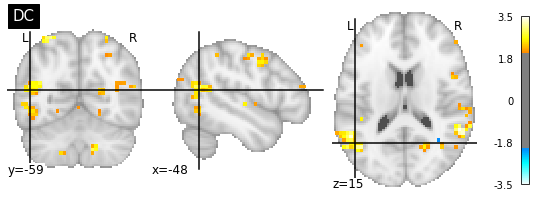

In [22]:
# static atlas
dc_img = brain_masker.inverse_transform(
    dc_scaled.T)
display = plotting.plot_stat_map(dc_img,
                                 threshold=2, vmax=3.5,
                                 #cut_coords=pcc_coords[0],
                                 title="DC"
                                 )


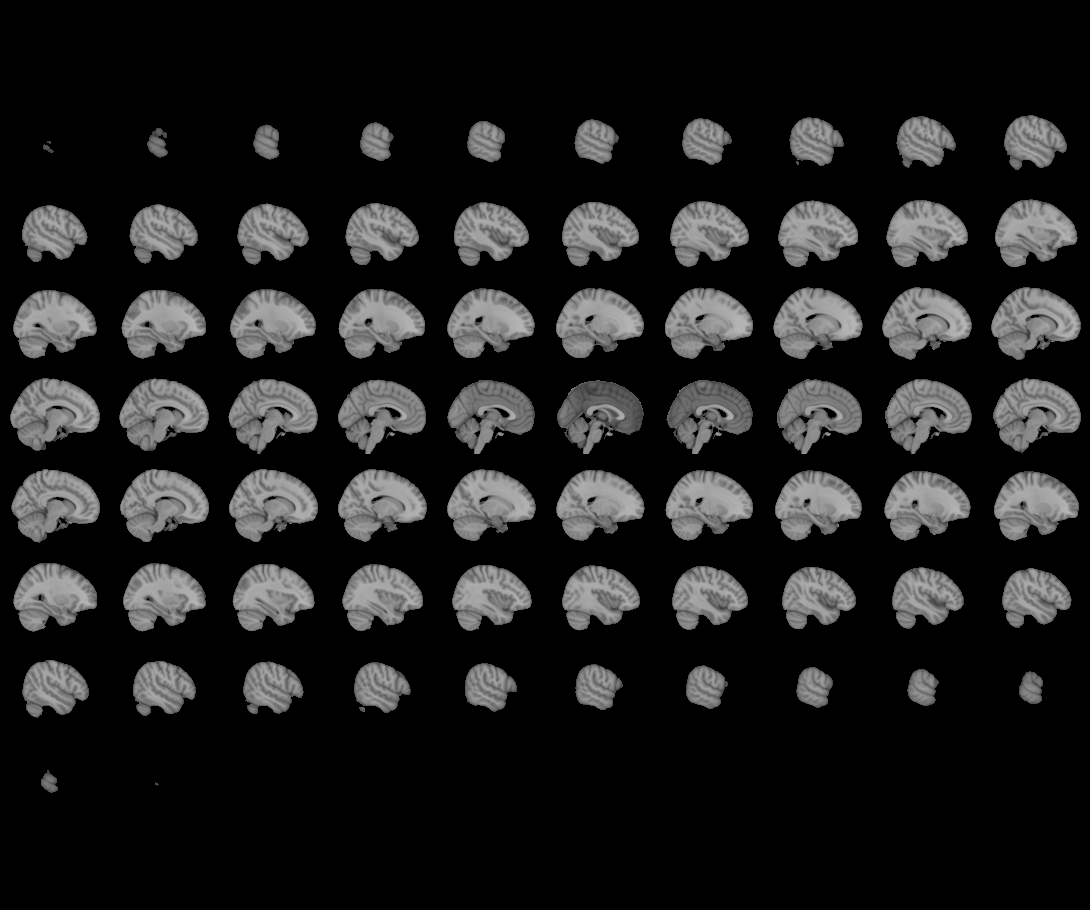
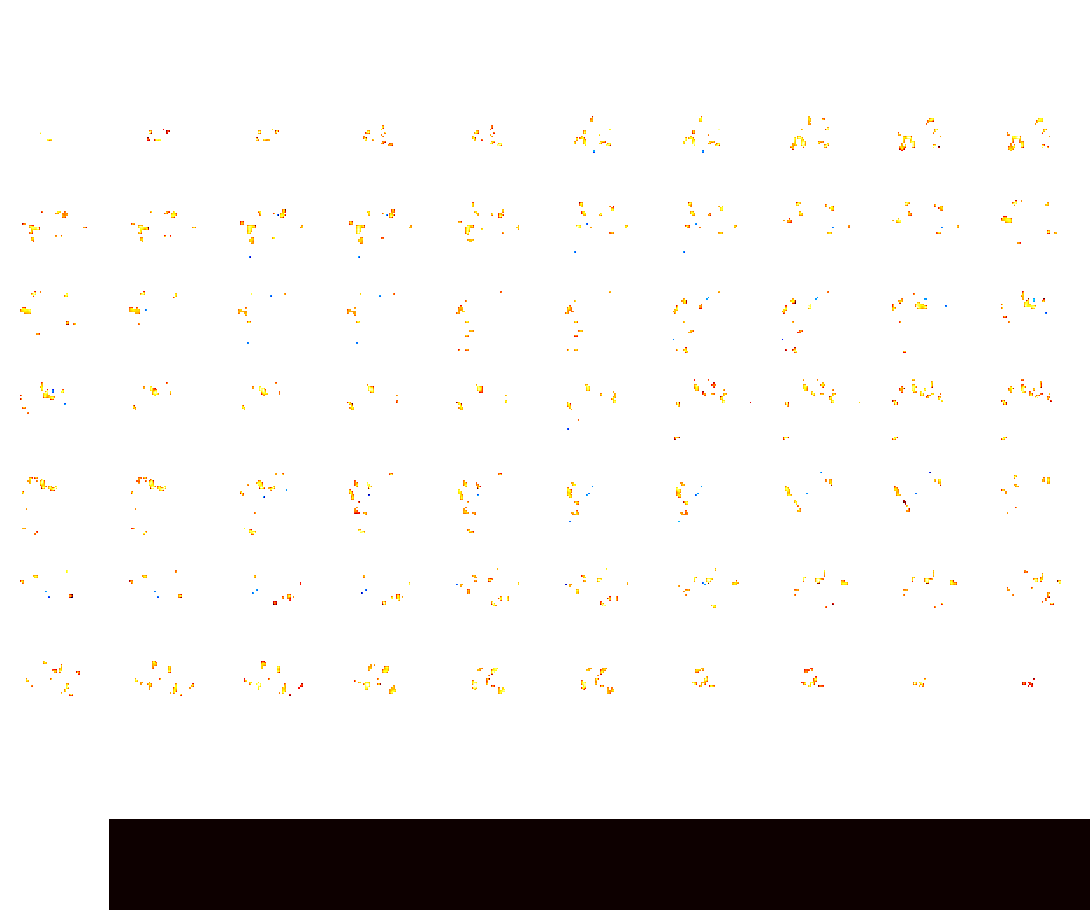

In [23]:
# interactive atlas
plotting.view_img(dc_img,
                     threshold=2, vmax=3.5,
                     #cut_coords=pcc_coords[0],
                     title="DC"
                     )

In [ ]:
# continue with all participants [choose which ones!!!]

In [ ]:
# check if IQ and Age are significantly different between ASD and TD groups

In [ ]:
# load the excel file (encrypted!!) and the 3rd sheet
# split the dataframe into ASD and TD
# do a t-test on both factors

In [ ]:
# copy all of the FD files into a single folder on the NaN, archive it and download the archive
# get the mean FD vals for each participant and add them to the age/IQ dataframe
# check whether these 3 factors are significantly different between the ASD and TD groups

In [ ]:
# create a dataframe from the text files in the FD folder
# get the mean(and median) values for each participant (N.B. some have 1, some 2 and other all 3 visits!!!!!)

In [34]:
fd_list = []
fd_file_paths = sorted(glob.glob("/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/*.txt"))
fd_file_paths

['/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F001_A_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F001_B_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F002_B_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F002_C_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F003_A_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F003_B_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F003_C_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F004_A_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F004_B_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F004_C_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F005_A_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD/F005_C_fd_metric.txt',
 '/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC

In [35]:
# get the session IDs for the whole dataset
root_dir = "/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/FD"
fd_session_names_list = [os.path.relpath(os.path.join(dirpath, file), root_dir) for (dirpath, dirnames, filenames) in os.walk(root_dir) for file in filenames]
fd_session_names_list.sort()
fd_session_names_list

['F001_A_fd_metric.txt',
 'F001_B_fd_metric.txt',
 'F002_B_fd_metric.txt',
 'F002_C_fd_metric.txt',
 'F003_A_fd_metric.txt',
 'F003_B_fd_metric.txt',
 'F003_C_fd_metric.txt',
 'F004_A_fd_metric.txt',
 'F004_B_fd_metric.txt',
 'F004_C_fd_metric.txt',
 'F005_A_fd_metric.txt',
 'F005_C_fd_metric.txt',
 'F006_A_fd_metric.txt',
 'F006_B_fd_metric.txt',
 'F006_C_fd_metric.txt',
 'F007_B_fd_metric.txt',
 'F007_C_fd_metric.txt',
 'F008_A_fd_metric.txt',
 'F008_B_fd_metric.txt',
 'F008_C_fd_metric.txt',
 'F009_A_fd_metric.txt',
 'F009_B_fd_metric.txt',
 'F009_C_fd_metric.txt',
 'F010_A_fd_metric.txt',
 'F010_B_fd_metric.txt',
 'F011_A_fd_metric.txt',
 'F011_B_fd_metric.txt',
 'F011_C_fd_metric.txt',
 'F012_A_fd_metric.txt',
 'F012_B_fd_metric.txt',
 'F012_C_fd_metric.txt',
 'F013_A_fd_metric.txt',
 'F013_B_fd_metric.txt',
 'F014_A_fd_metric.txt',
 'F014_B_fd_metric.txt',
 'F014_C_fd_metric.txt',
 'F016_A_fd_metric.txt',
 'F016_C_fd_metric.txt',
 'F103_A_fd_metric.txt',
 'F103_B_fd_metric.txt',


In [36]:
for i in range(len(fd_file_paths)):
        # get an MRI session file
        single_session = pd.read_csv(fd_file_paths[i])
        fd_list.append(single_session)

In [39]:
len(fd_list)

172

In [40]:
# concatenate all pandas files from the fd_list
fd_df = pd.concat(fd_list, axis=1)
fd_df

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0.072379,0.029045,0.355093,0.108987,0.121223,0.062049,0.380108,0.211466,0.067796,0.087473,...,0.187187,0.042003,0.142170,0.070819,0.173079,0.367161,0.109972,0.084979,0.073715,0.118679
1,0.063663,0.089517,0.352684,0.166796,0.090234,0.056163,0.117567,0.072300,0.324173,0.316315,...,0.209304,0.088706,0.057896,0.080338,0.155615,0.301751,0.164988,0.057940,0.100513,0.052887
2,0.078723,0.139793,0.128950,0.044818,0.117326,0.160719,0.077119,0.145113,0.378976,0.361107,...,0.225840,0.066366,0.090410,0.064457,0.252132,0.083282,0.285979,0.047597,0.078916,0.039983
3,0.039835,0.131848,0.099180,0.044453,0.067552,0.052409,0.075539,0.075172,0.282192,0.178385,...,0.142426,0.049054,0.046312,0.060160,0.281290,0.341450,0.167849,0.039121,0.069304,0.076533
4,0.058933,0.020153,0.033633,0.057046,0.060776,0.138877,0.087284,0.227279,0.086462,0.051258,...,0.272157,0.076230,0.069982,0.065025,0.198186,0.399233,0.096924,0.088348,0.078815,0.052093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.066923,0.109169,0.119507,0.045001,0.082952,0.327337,0.076191,0.413806,0.198743,0.275391,...,0.979535,0.032652,0.076702,0.075211,1.085520,0.216286,0.104560,0.055090,0.084642,0.057978
187,0.136275,0.058001,0.088704,0.050908,0.063742,0.298738,0.089262,0.145554,0.052674,0.050633,...,2.301810,0.034281,0.088052,0.136443,0.661155,0.258071,0.108955,0.079971,0.044123,0.063991
188,0.086803,0.123845,0.093402,0.062275,0.119208,0.160403,0.092462,0.428340,0.310469,0.276659,...,1.453670,0.023346,0.066430,0.120561,0.402713,0.259715,0.091997,0.103695,0.080495,0.121208
189,0.165699,0.085386,0.115176,0.054365,0.081351,0.233525,0.058442,0.228758,0.117082,0.206330,...,0.385485,0.031575,0.061218,0.113713,1.069890,0.229511,0.124755,0.167124,0.321586,0.076426


In [41]:
# set column names
fd_df.columns = fd_session_names_list
fd_df

,F001_A_fd_metric.txt,F001_B_fd_metric.txt,F002_B_fd_metric.txt,F002_C_fd_metric.txt,F003_A_fd_metric.txt,F003_B_fd_metric.txt,F003_C_fd_metric.txt,F004_A_fd_metric.txt,F004_B_fd_metric.txt,F004_C_fd_metric.txt,...,M119_C_fd_metric.txt,M120_A_fd_metric.txt,M120_B_fd_metric.txt,M120_C_fd_metric.txt,M121_A_fd_metric.txt,M121_B_fd_metric.txt,M121_C_fd_metric.txt,M122_A_fd_metric.txt,M130_B_fd_metric.txt,M130_C_fd_metric.txt
0,0.072379,0.029045,0.355093,0.108987,0.121223,0.062049,0.380108,0.211466,0.067796,0.087473,...,0.187187,0.042003,0.142170,0.070819,0.173079,0.367161,0.109972,0.084979,0.073715,0.118679
1,0.063663,0.089517,0.352684,0.166796,0.090234,0.056163,0.117567,0.072300,0.324173,0.316315,...,0.209304,0.088706,0.057896,0.080338,0.155615,0.301751,0.164988,0.057940,0.100513,0.052887
2,0.078723,0.139793,0.128950,0.044818,0.117326,0.160719,0.077119,0.145113,0.378976,0.361107,...,0.225840,0.066366,0.090410,0.064457,0.252132,0.083282,0.285979,0.047597,0.078916,0.039983
3,0.039835,0.131848,0.099180,0.044453,0.067552,0.052409,0.075539,0.075172,0.282192,0.178385,...,0.142426,0.049054,0.046312,0.060160,0.281290,0.341450,0.167849,0.039121,0.069304,0.076533
4,0.058933,0.020153,0.033633,0.057046,0.060776,0.138877,0.087284,0.227279,0.086462,0.051258,...,0.272157,0.076230,0.069982,0.065025,0.198186,0.399233,0.096924,0.088348,0.078815,0.052093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.066923,0.109169,0.119507,0.045001,0.082952,0.327337,0.076191,0.413806,0.198743,0.275391,...,0.979535,0.032652,0.076702,0.075211,1.085520,0.216286,0.104560,0.055090,0.084642,0.057978
187,0.136275,0.058001,0.088704,0.050908,0.063742,0.298738,0.089262,0.145554,0.052674,0.050633,...,2.301810,0.034281,0.088052,0.136443,0.661155,0.258071,0.108955,0.079971,0.044123,0.063991
188,0.086803,0.123845,0.093402,0.062275,0.119208,0.160403,0.092462,0.428340,0.310469,0.276659,...,1.453670,0.023346,0.066430,0.120561,0.402713,0.259715,0.091997,0.103695,0.080495,0.121208
189,0.165699,0.085386,0.115176,0.054365,0.081351,0.233525,0.058442,0.228758,0.117082,0.206330,...,0.385485,0.031575,0.061218,0.113713,1.069890,0.229511,0.124755,0.167124,0.321586,0.076426


In [43]:
fd_df.columns = fd_df.columns.str.rstrip('_fd_metric.txt')
fd_df

,F001_A,F001_B,F002_B,F002_C,F003_A,F003_B,F003_C,F004_A,F004_B,F004_C,...,M119_C,M120_A,M120_B,M120_C,M121_A,M121_B,M121_C,M122_A,M130_B,M130_C
0,0.072379,0.029045,0.355093,0.108987,0.121223,0.062049,0.380108,0.211466,0.067796,0.087473,...,0.187187,0.042003,0.142170,0.070819,0.173079,0.367161,0.109972,0.084979,0.073715,0.118679
1,0.063663,0.089517,0.352684,0.166796,0.090234,0.056163,0.117567,0.072300,0.324173,0.316315,...,0.209304,0.088706,0.057896,0.080338,0.155615,0.301751,0.164988,0.057940,0.100513,0.052887
2,0.078723,0.139793,0.128950,0.044818,0.117326,0.160719,0.077119,0.145113,0.378976,0.361107,...,0.225840,0.066366,0.090410,0.064457,0.252132,0.083282,0.285979,0.047597,0.078916,0.039983
3,0.039835,0.131848,0.099180,0.044453,0.067552,0.052409,0.075539,0.075172,0.282192,0.178385,...,0.142426,0.049054,0.046312,0.060160,0.281290,0.341450,0.167849,0.039121,0.069304,0.076533
4,0.058933,0.020153,0.033633,0.057046,0.060776,0.138877,0.087284,0.227279,0.086462,0.051258,...,0.272157,0.076230,0.069982,0.065025,0.198186,0.399233,0.096924,0.088348,0.078815,0.052093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0.066923,0.109169,0.119507,0.045001,0.082952,0.327337,0.076191,0.413806,0.198743,0.275391,...,0.979535,0.032652,0.076702,0.075211,1.085520,0.216286,0.104560,0.055090,0.084642,0.057978
187,0.136275,0.058001,0.088704,0.050908,0.063742,0.298738,0.089262,0.145554,0.052674,0.050633,...,2.301810,0.034281,0.088052,0.136443,0.661155,0.258071,0.108955,0.079971,0.044123,0.063991
188,0.086803,0.123845,0.093402,0.062275,0.119208,0.160403,0.092462,0.428340,0.310469,0.276659,...,1.453670,0.023346,0.066430,0.120561,0.402713,0.259715,0.091997,0.103695,0.080495,0.121208
189,0.165699,0.085386,0.115176,0.054365,0.081351,0.233525,0.058442,0.228758,0.117082,0.206330,...,0.385485,0.031575,0.061218,0.113713,1.069890,0.229511,0.124755,0.167124,0.321586,0.076426


In [46]:
fd_df_mean = fd_df.mean(axis=0)
fd_df_mean

F001_A    0.076392
F001_B    0.096095
F002_B    0.095914
F002_C    0.073806
F003_A    0.104469
            ...   
M121_B    0.179690
M121_C    0.168767
M122_A    0.150527
M130_B    0.097723
M130_C    0.203901
Length: 172, dtype: float64

In [48]:
fd_df_mean.to_excel("mean_fd.xlsx")

In [53]:
fd_data = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/mean_fd_split.xlsx', sheet_name='Sheet3', engine='openpyxl')

In [54]:
fd_data_td = fd_data.iloc[:,0]
print(fd_data_td)
fd_data_asd = fd_data.iloc[:,1]
print(fd_data_asd)

0     0.076392
1     0.096095
2     0.095914
3     0.073806
4     0.104469
        ...   
94    0.135386
95    0.164924
96    0.253277
97    0.121001
98    0.056662
Name: TD, Length: 99, dtype: float64
0     0.068508
1     0.096285
2     0.141920
3     0.565447
4     0.207040
        ...   
94         NaN
95         NaN
96         NaN
97         NaN
98         NaN
Name: ASD, Length: 99, dtype: float64


In [62]:
# since there are less values in the ASD group, let's fill the missing values using the mean FD of the existing ASD values
fd_asd_mean = fd_data_asd.mean()
fd_data_asd = fd_data_asd.fillna(fd_asd_mean)
fd_data_asd

0     0.068508
1     0.096285
2     0.141920
3     0.565447
4     0.207040
        ...   
94    0.218437
95    0.218437
96    0.218437
97    0.218437
98    0.218437
Name: ASD, Length: 99, dtype: float64

In [63]:
#find variance for each group
print(np.var(fd_data_td), np.var(fd_data_asd))

0.033413300692674244 0.016714079367979078


In [64]:
# there is about a two-fold difference, so we can thus assume equal variance 
# N.B. the scipy algorithm automatically checks and if the assumption is violated, performs Welch's t-test instead!
# perform a two-sample t-test on FD data
stats.ttest_ind(a=fd_data_td, b=fd_data_asd, equal_var=True)

Ttest_indResult(statistic=-1.6675289913246814, pvalue=0.09700620423547801)

In [ ]:
# not significantly different!!

In [ ]:
# let's check the age and IQ as well

In [66]:
# age
df_age_all = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/ARB_cov_split.xlsx', sheet_name='Age', engine='openpyxl')
df_age_td = df_age_all.iloc[:,0]
print(df_age_td)
df_age_asd = df_age_all.iloc[:,1]
print(df_age_asd)

0     29
1     29
2     35
3     25
4     24
5     26
6     37
7     25
8     34
9     27
10    26
11    19
12    22
13    19
14    20
15    33
16    26
17    52
18    23
19    18
20    20
21    23
22    19
23    36
24    27
25    27
26    22
27    24
28    37
29    28
30    26
31    28
32    30
33    51
34    34
35    39
36    27
Name: TD, dtype: int64
0     40.0
1     46.0
2     34.0
3     26.0
4     34.0
5     50.0
6     34.0
7     24.0
8     36.0
9     51.0
10    40.0
11    33.0
12    25.0
13    30.0
14    19.0
15    33.0
16    30.0
17    19.0
18    40.0
19    43.0
20    25.0
21    49.0
22    36.0
23    29.0
24    21.0
25    49.0
26    47.0
27     NaN
28     NaN
29     NaN
30     NaN
31     NaN
32     NaN
33     NaN
34     NaN
35     NaN
36     NaN
Name: ASD, dtype: float64


In [72]:
# DROP THE NaN VALUES RATHER THAN REPLACING THEM????????????????????

#age_asd_mean = df_age_asd.mean()
#df_age_asd = df_age_asd.fillna(age_asd_mean)
#df_age_asd

In [70]:
#find variance for each group
#print(np.var(df_age_td), np.var(df_age_asd))

In [71]:
# we can thus assume equal variance 
# perform a two-sample t-test on the age data
#stats.ttest_ind(a=df_age_td, b=df_age_asd, equal_var=True)

In [ ]:
# IQ:


In [23]:
# load the whole dataset
rootDir = "/Volumes/Seagate Dr/PhD/Chapter 2"
full_fmri_list = [os.path.relpath(os.path.join(dirpath, file), rootDir) for (dirpath, dirnames, filenames) in os.walk(rootDir) for file in filenames]
full_fmri_list

['F001_A.nii',
 'F001_B.nii',
 'F002_B.nii',
 'F002_C.nii',
 'F003_A.nii',
 'F003_B.nii',
 'F003_C.nii',
 'F004_A.nii',
 'F004_B.nii',
 'F004_C.nii',
 'F005_A.nii',
 'F005_C.nii',
 'F006_A.nii',
 'F006_B.nii',
 'F006_C.nii',
 'F007_B.nii',
 'F007_C.nii',
 'F008_A.nii',
 'F008_B.nii',
 'F008_C.nii',
 'F009_A.nii',
 'F009_B.nii',
 'F009_C.nii',
 'F010_A.nii',
 'F010_B.nii',
 'F011_A.nii',
 'F011_B.nii',
 'F011_C.nii',
 'F012_A.nii',
 'F012_B.nii',
 'F012_C.nii',
 'F013_A.nii',
 'F013_B.nii',
 'F014_A.nii',
 'F014_B.nii',
 'F014_C.nii',
 'F016_A.nii',
 'F016_C.nii',
 'F103_A.nii',
 'F103_B.nii',
 'F103_C.nii',
 'F104_A.nii',
 'F106_A.nii',
 'F106_B.nii',
 'F107_A.nii',
 'F107_B.nii',
 'F107_C.nii',
 'F109_A.nii',
 'F109_C.nii',
 'F110_A.nii',
 'F110_B.nii',
 'F110_C.nii',
 'M001_A.nii',
 'M001_B.nii',
 'M001_C.nii',
 'M002_A.nii',
 'M002_B.nii',
 'M002_C.nii',
 'M003_A.nii',
 'M004_A.nii',
 'M004_B.nii',
 'M004_C.nii',
 'M005_A.nii',
 'M005_B.nii',
 'M005_C.nii',
 'M006_A.nii',
 'M006_B.n

In [27]:
# path to the fMRI folder
fmri_image_folder = "/Volumes/Seagate Dr/PhD/Chapter 2"

# empty dictionary to be filled with participant IDs and corresponding DC values
dc_vals = {}

# to create an undirected, weighted graph
def to_graph_tool(adj):
    g = gt.Graph(directed=False)
    edge_weights = g.new_edge_property('double')
    g.edge_properties['weight'] = edge_weights
    nnz = np.nonzero(np.triu(adj,1))
    nedges = len(nnz[0])
    g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
    return g


# to calculate functional connectivity and degree centrality
def calc_dc(fmri_list):
    for i in range(len(fmri_list)):
        # load an image from a single brain:
        fmri_image_path = os.path.join(fmri_image_folder, fmri_list[i])
        fmri_image = nib.load(fmri_image_path)
        print("Participant " + fmri_list[i])
        print("The image dimensions are: " + str(fmri_image.shape))
        
        # create a NiftiMasker object
        brain_masker = input_data.NiftiMasker(group_mask, detrend=True, standardize=True, t_r=2.5, 
                                              memory='nilearn_cache', memory_level=1, verbose=0)
        brain_time_series = brain_masker.fit_transform(fmri_image)
        
        # calculate the correlations between each pair of voxels
        voxel_to_voxel_correlations = (np.matmul(brain_time_series.T, brain_time_series) /
                                      brain_time_series.shape[0])
        print("Correlations calculated.")
        
        # threshold at r > 0.25
        correlation_matrix = voxel_to_voxel_correlations
        correlation_matrix[correlation_matrix < 0.25] = 0
        print("Correlation matrix thresholded.")
        
        # fill diagonal with zeroes
        np.fill_diagonal(correlation_matrix, 0)
        print("Correlation matrix diagonal set to 0.")
        
        # calculate the degree centrality (DC)
        g = to_graph_tool(correlation_matrix)
        dc = g.get_total_degrees([i for i in range(brain_time_series.shape[1])])
        print("DC values calcualted.")
        
        # z-score the DC values
        scaler = StandardScaler()
        dc = dc.reshape(-1, 1)
        dc_scaled = scaler.fit_transform(dc)
        print("DC values z-scored.")

        # add the dc values and their matching participant ID to the dc_vals dictionary
        dc_vals[fmri_list[i]] = dc_scaled
        print("Dictionary updated.")

In [25]:
small_fmri_list = full_fmri_list[0:2]
small_fmri_list

['F001_A.nii', 'F001_B.nii']

In [41]:
calc_dc(full_fmri_list)

Participant F001_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F001_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F002_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F002_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F003_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation 

DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F016_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F103_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F103_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F103_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F104_A.nii
The image dimension

Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M009_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M009_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M009_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M010_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values

/opt/anaconda3/envs/Project_2_ARB/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:398: UserWarning: Persisting input arguments took 0.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M015_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M016_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M016_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M016_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values

Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M107_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M108_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M108_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M108_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values

Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M121_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M121_C.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M122_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant M130_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values

In [ ]:
dc_vals

In [42]:
# save the dictionary to a file
# https://www.quora.com/How-can-I-store-dictionaries-in-Python
# https://pythonspot.com/save-a-dictionary-to-a-file/

import pickle
f = open("dc_vals.pkl","wb")
pickle.dump(dc_vals,f)
f.close()

In [ ]:
# A > B contrast - just a test
# https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_two_sample_test.html

In [33]:
from nilearn.datasets import fetch_localizer_contrasts
n_subjects = 16
sample_vertical = fetch_localizer_contrasts(
    ["vertical checkerboard"], n_subjects, get_tmaps=True)
sample_horizontal = fetch_localizer_contrasts(
    ["horizontal checkerboard"], n_subjects, get_tmaps=True)
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

/opt/anaconda3/envs/Project_2_ARB/lib/python3.9/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [70]:
second_level_input

['/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S02/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S03/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S04/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S05/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S06/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S07/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S08/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S09/cmaps_VerticalCheck

<AxesSubplot:label='conditions', ylabel='scan number'>

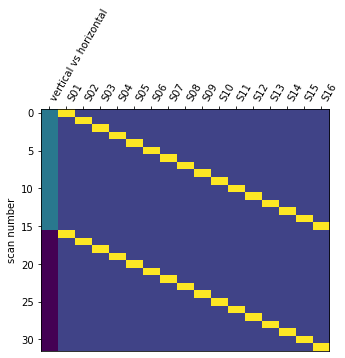

In [34]:
#We define the input maps and the design matrix for the second level model and fit it.
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

#Next, we model the effect of conditions (sample 1 vs sample 2).

condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))

#Subsequently, we can model the subject effect: each subject is observed in sample 1 and sample 2.

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = ['S%02d' % i for i in range(1, n_subjects + 1)]

#We then assemble those in a design matrix and

design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=['vertical vs horizontal'] + subjects)

#plot the design_matrix.
plot_design_matrix(design_matrix)

In [ ]:
second_level_input = dc_vals['F001_A.nii'] + dc_vals['F001_B.nii']

In [39]:
#n_subjects = 2
condition_effect = np.array((1, -1))
condition_effect

array([ 1, -1])

In [ ]:
#We then assemble those in a design matrix and

design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=['vertical vs horizontal'] + subjects)

#plot the design_matrix.
plot_design_matrix(design_matrix)

In [40]:
# https://nilearn.github.io/modules/generated/nilearn.plotting.plot_design_matrix.html

In [ ]:
# Generate summary statistics for both groups (ASD, TD) and all 3 drug conditions??????

In [ ]:
# plot DC results using the brain atlas coordinates and anatomical labels.. use nilearn plotting????????? (https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html)

In [ ]:
# Get all the non-imaging data - clean it up, pre-process it, scale it etc.

In [ ]:
# PCA (and CCA????) for dimensionality reduction 

In [ ]:
# Set-up the different contrasts

In [ ]:
# Assess the statistical significance